In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/content')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [3]:
loan_df = pd.read_pickle('/content/clean_df.pkl')

In [4]:
loan_df.groupby(['fully_paid']).size()

,0
fully_paid,
0,245205
1,958477


In [5]:
loan_df.fully_paid.value_counts(normalize = True)

,proportion
fully_paid,
1,0.796288
0,0.203712


In [6]:
# Stratified sampling to maintain proportions of 'fully_paid'
subset_size = 200000

# Calculate the sample size for each category in the target column
proportions = loan_df['fully_paid'].value_counts(normalize=True)
sample_sizes = (proportions * subset_size).round().astype(int)

# Perform stratified sampling on the target column
loan_df = (
    loan_df.groupby('fully_paid', group_keys=False)
    .apply(lambda group: group.sample(n=sample_sizes[group.name], random_state=42))
)

loan_df.fully_paid.value_counts(normalize = True)

,proportion
fully_paid,
1,0.79629
0,0.20371


Correlation Analysis

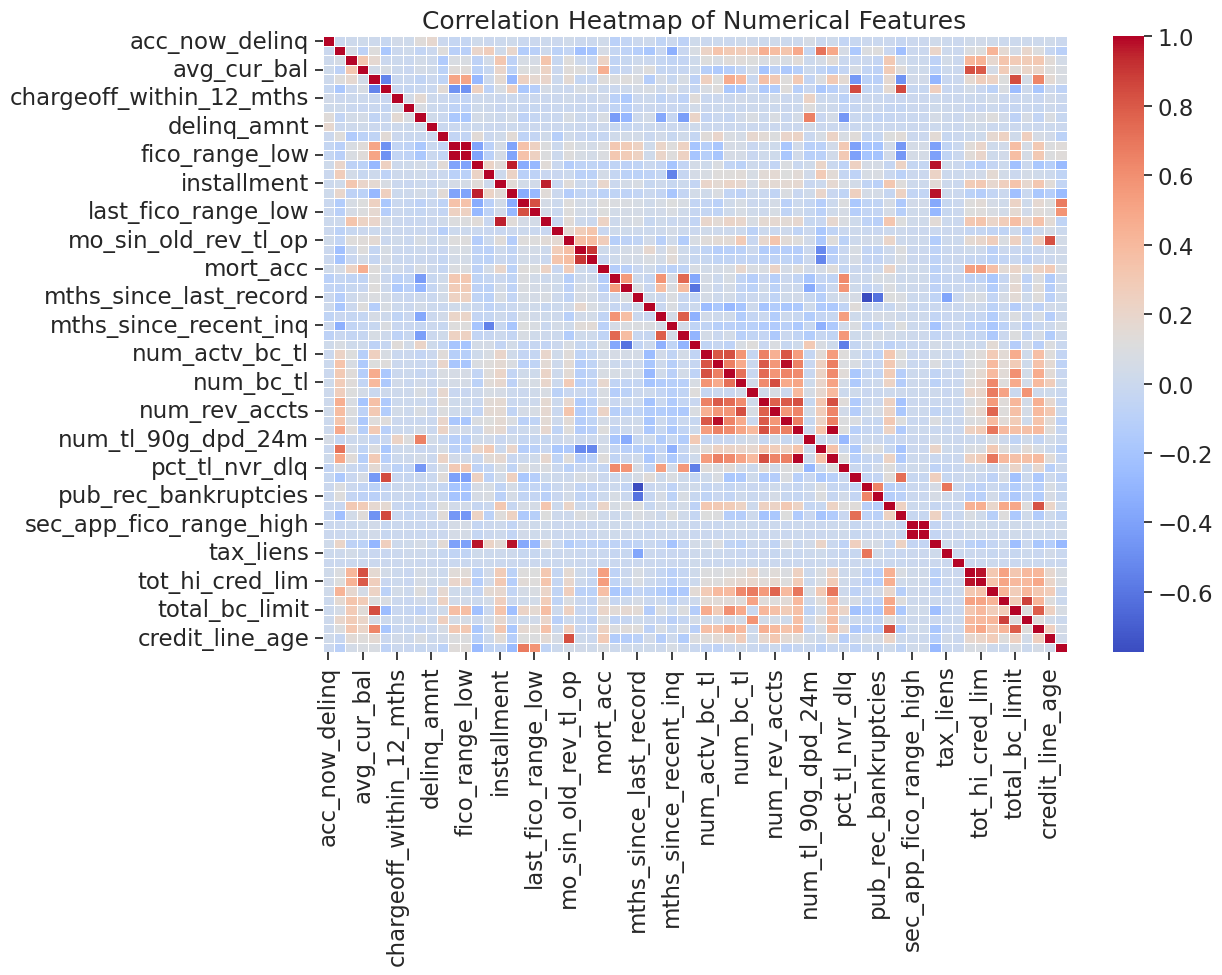

In [7]:
# Select numeric columns
numeric_columns = loan_df.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix for numeric columns only
correlation_matrix = loan_df[numeric_columns].corr()

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()



High Cardinality

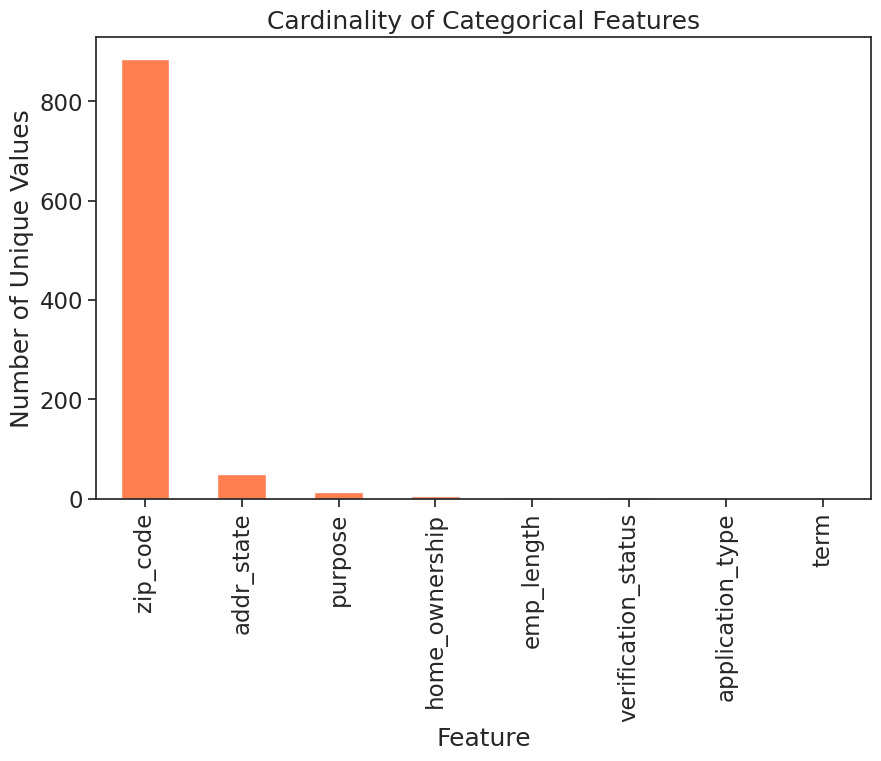

In [8]:
# Check unique values in categorical features
categorical_features = loan_df.select_dtypes(include=['object']).nunique()

# Plot cardinality
categorical_features.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), color="coral")
plt.title("Cardinality of Categorical Features")
plt.xlabel("Feature")
plt.ylabel("Number of Unique Values")
plt.show()


 Variance Analysis

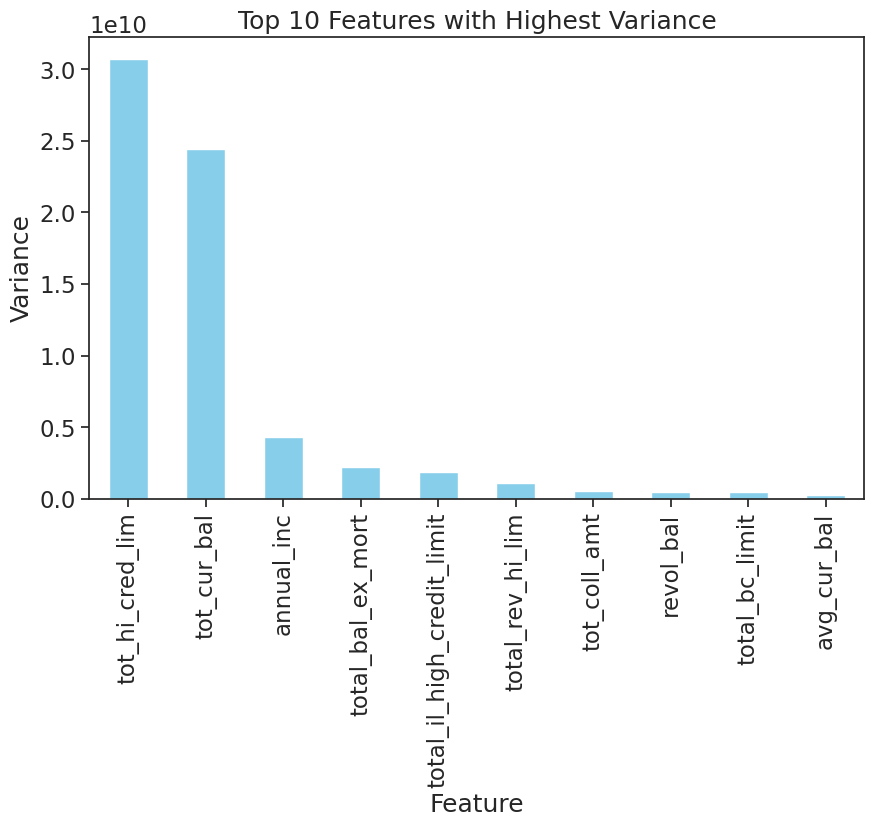

In [9]:
# Variance of numerical features
variances = loan_df.select_dtypes(include=['float64', 'int64']).var()

# Plot variance of top features
variances.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 6), color="skyblue")
plt.title("Top 10 Features with Highest Variance")
plt.xlabel("Feature")
plt.ylabel("Variance")
plt.show()


Dropping the columns

In [10]:
# Variables to drop based on our analysis
columns_to_drop = [
    'grade',  # Redundant as 'sub_grade' was more granular
    'sub_grade',  # Highly categorical; removed due to encoding complexity
    'installment',  # Correlated with 'loan_amnt'
    'int_rate',  # Highly correlated with 'fico_range_high'
    'zip_code',  # High cardinality, not directly related to loan repayment
    'issue_d',  # Date information unlikely to influence repayment
    'tot_hi_cred_lim',  # High variance but redundant with 'total_bc_limit'
    'tot_cur_bal',  # High variance but less informative compared to other balances
    'annual_inc',  # Less influential based on feature importance
    'total_rev_hi_lim',  # Redundant with 'total_bc_limit'
]

# Drop the selected columns
loan_df_cleaned = loan_df.drop(columns=columns_to_drop, errors='ignore')

# Verify the shape of the dataset after dropping columns
print(f"Original dataset shape: {loan_df.shape}")
print(f"Cleaned dataset shape: {loan_df_cleaned.shape}")

# Display the remaining columns
print("\nRemaining columns:")
print(loan_df_cleaned.columns)

Original dataset shape: (200000, 99)
Cleaned dataset shape: (200000, 89)

Remaining columns:
Index(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'fico_range_high', 'fico_range_low', 'inq_last_6mths',
       'last_fico_range_high', 'last_fico_range_low', 'loan_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op

Random Forest Classifier


Random Forest Performance (with Imbalanced Training Set):
Accuracy: 0.5017
ROC AUC: 0.9571

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      5000
           1       0.50      1.00      0.67      5000

    accuracy                           0.50     10000
   macro avg       0.75      0.50      0.34     10000
weighted avg       0.75      0.50      0.34     10000



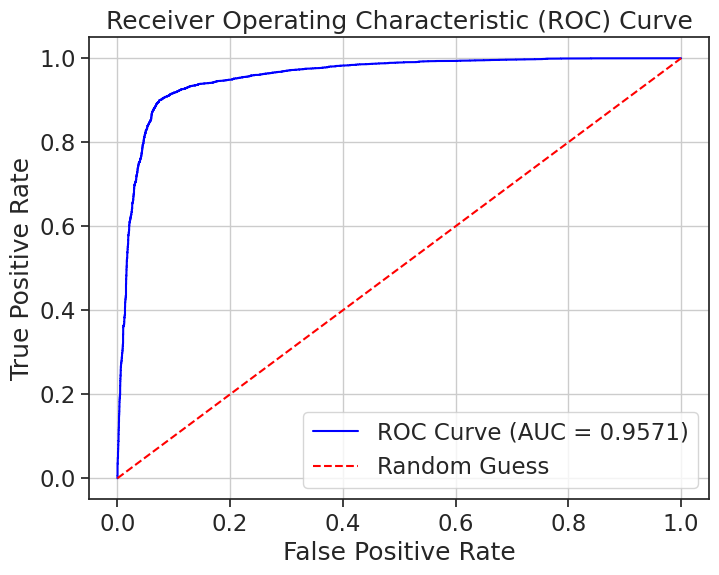

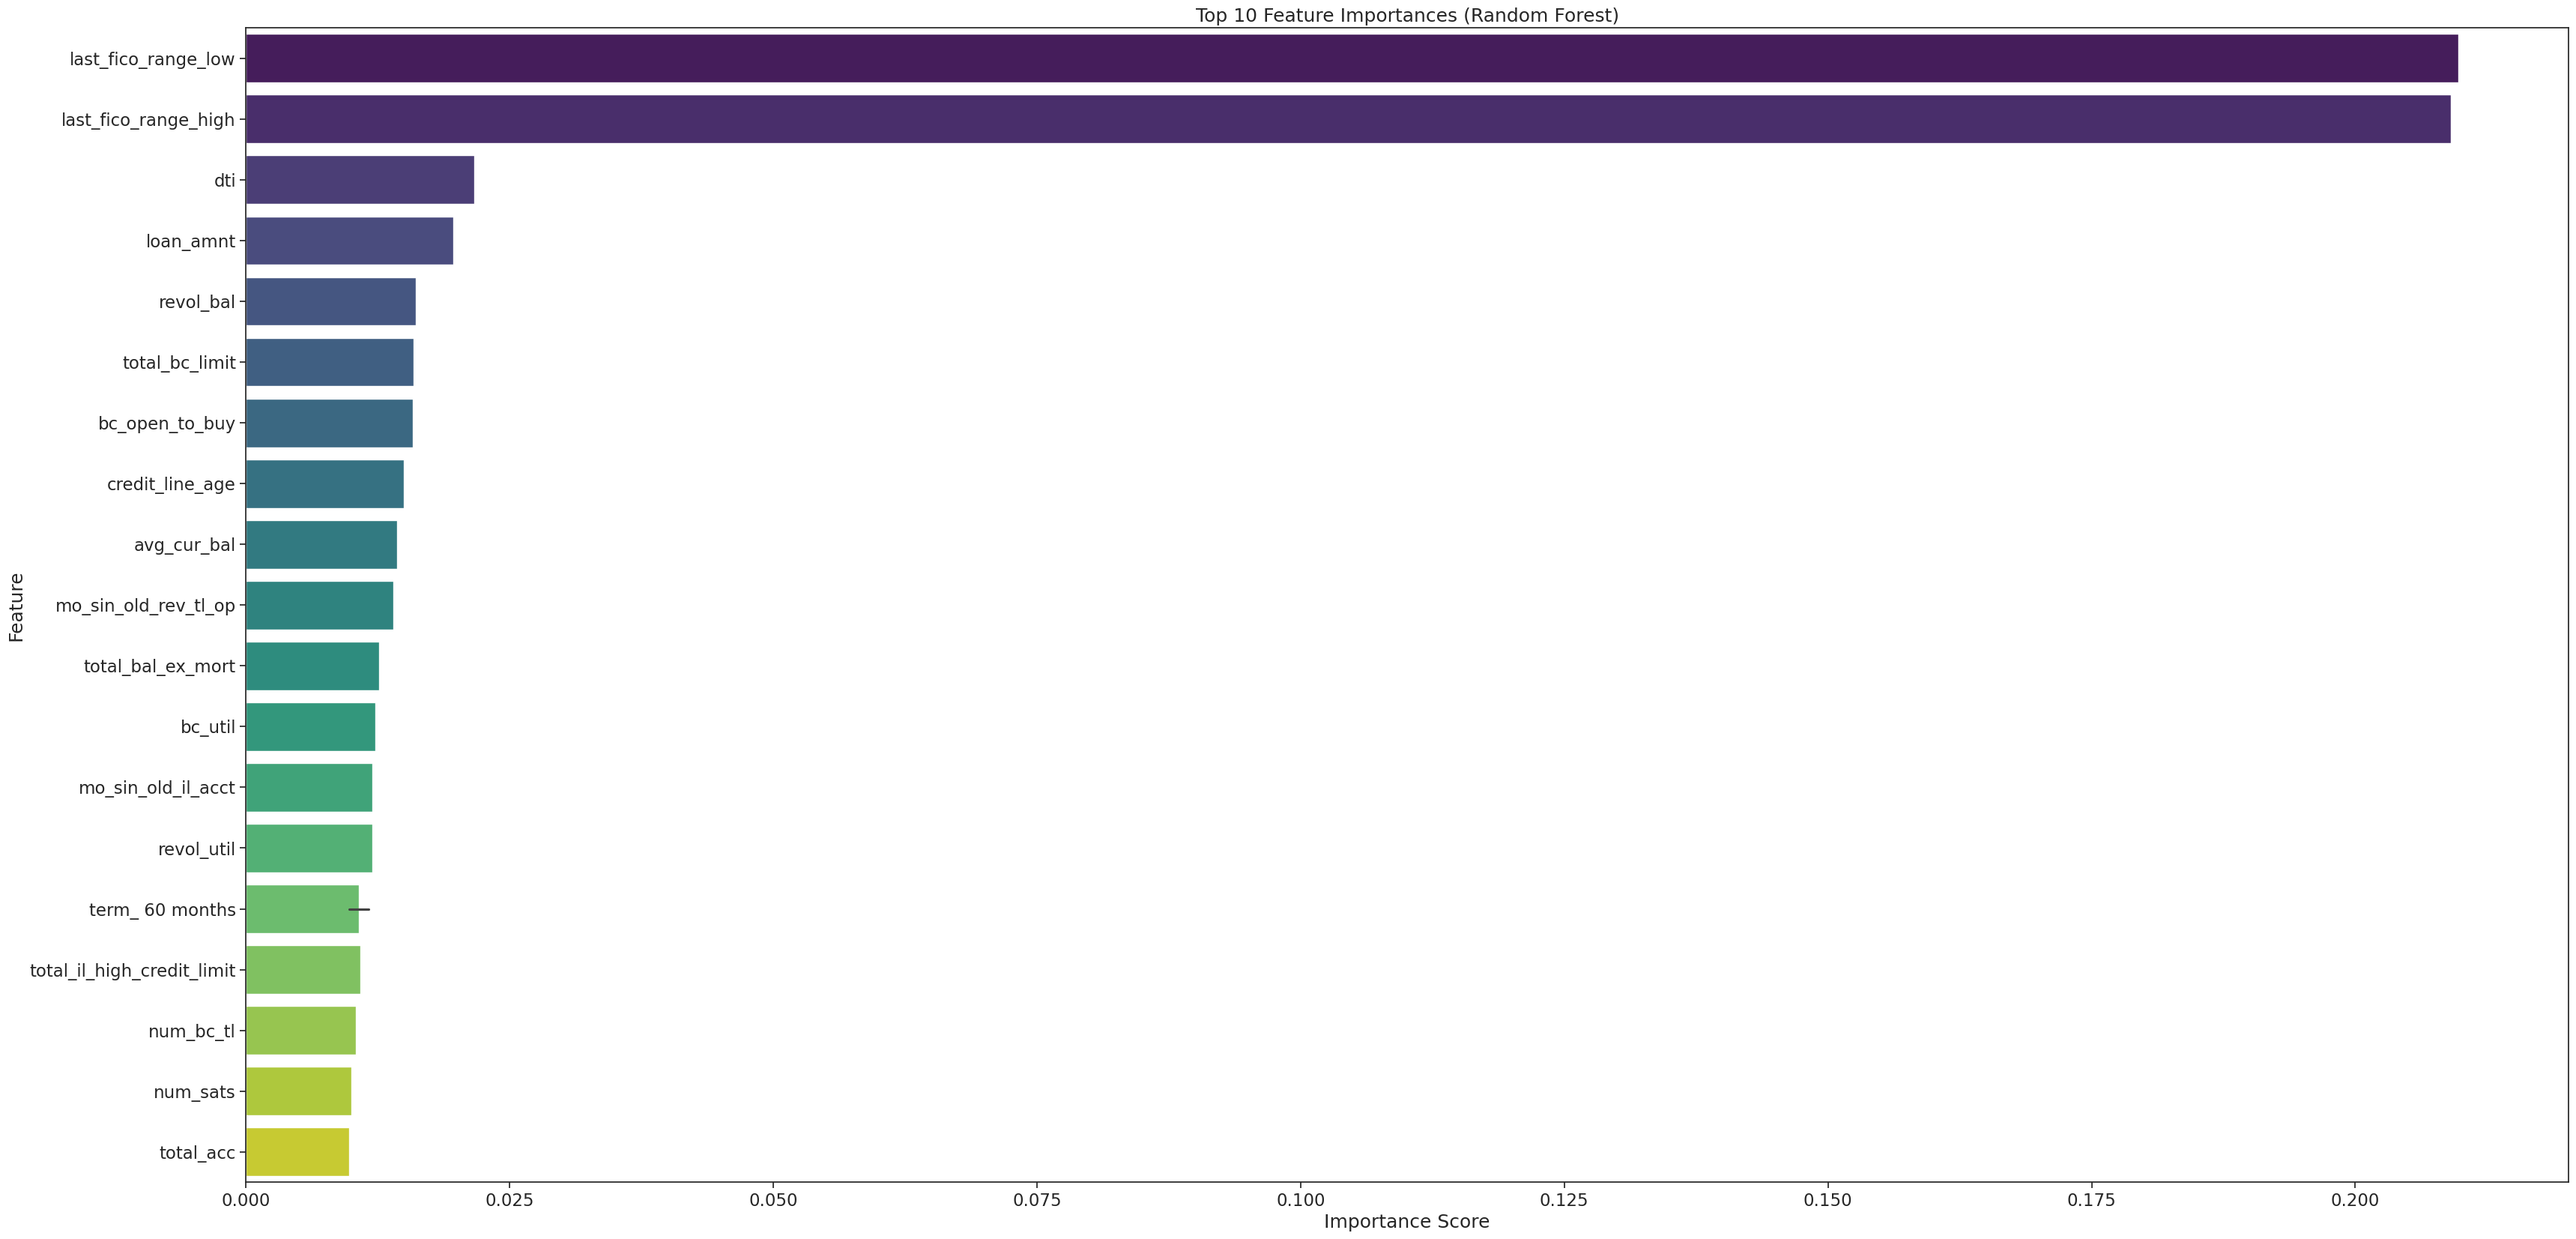

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure column names are consistent
loan_df_cleaned.columns = loan_df_cleaned.columns.astype(str)

# Define features and target variable
X = loan_df_cleaned.drop(columns=['fully_paid'], errors='ignore')  # Features
y = loan_df_cleaned['fully_paid']  # Target variable

# Ensure all feature column names are strings
X.columns = X.columns.astype(str)

# Identify categorical columns in the dataset
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Introduce Train-Test Split ----------
train_majority = loan_df_cleaned[loan_df_cleaned['fully_paid'] == 1].sample(frac=0.95, random_state=42)
train_minority = loan_df_cleaned[loan_df_cleaned['fully_paid'] == 0].sample(frac=0.05, random_state=42)
train_data = pd.concat([train_majority, train_minority])
X_train = train_data.drop(columns=['fully_paid'], errors='ignore')
y_train = train_data['fully_paid']

# Step 2: Create a balanced test set (50% '1', 50% '0')
test_majority = loan_df_cleaned[loan_df_cleaned['fully_paid'] == 1].sample(n=5000, random_state=42)
test_minority = loan_df_cleaned[loan_df_cleaned['fully_paid'] == 0].sample(n=5000, random_state=42)
test_data = pd.concat([test_majority, test_minority])
X_test = test_data.drop(columns=['fully_paid'], errors='ignore')
y_test = test_data['fully_paid']

# Ensure one-hot encoding is applied to training and test data
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Align the train and test feature sets (to ensure matching columns)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='inner', axis=1)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_encoded, y_train)

# Make predictions
y_pred = rf.predict(X_test_encoded)
y_proba = rf.predict_proba(X_test_encoded)[:, 1]

# Evaluate the model
print("\nRandom Forest Performance (with Imbalanced Training Set):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot feature importance
importances = rf.feature_importances_
features = X_train_encoded.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(40, 20))
sns.barplot(x=importances[indices][:20], y=features[indices][:20], palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [12]:
import joblib

# Save the trained model to a .pkl file
joblib.dump(rf, 'random_forest_model_f.pkl')

print("Model saved as random_forest_model_f.pkl")

Model saved as random_forest_model_f.pkl


XGB with flaw

[0]	train-auc:0.80080	test-auc:0.94493
[1]	train-auc:0.80394	test-auc:0.94650
[2]	train-auc:0.80548	test-auc:0.94759
[3]	train-auc:0.80738	test-auc:0.94772
[4]	train-auc:0.80840	test-auc:0.94828
[5]	train-auc:0.81067	test-auc:0.94843
[6]	train-auc:0.81228	test-auc:0.94882
[7]	train-auc:0.81336	test-auc:0.94920
[8]	train-auc:0.81594	test-auc:0.94880
[9]	train-auc:0.81684	test-auc:0.94879
[10]	train-auc:0.81772	test-auc:0.94871
[11]	train-auc:0.81989	test-auc:0.94835
[12]	train-auc:0.82144	test-auc:0.94843
[13]	train-auc:0.82336	test-auc:0.94841
[14]	train-auc:0.82414	test-auc:0.94830
[15]	train-auc:0.82555	test-auc:0.94829
[16]	train-auc:0.82701	test-auc:0.94822
[17]	train-auc:0.82821	test-auc:0.94805

XGBoost Performance (with Flawed Labels):
Accuracy: 0.9083
ROC AUC: 0.9480

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78     12194
           1       0.95      0.94      0.94     47806

    accuracy              

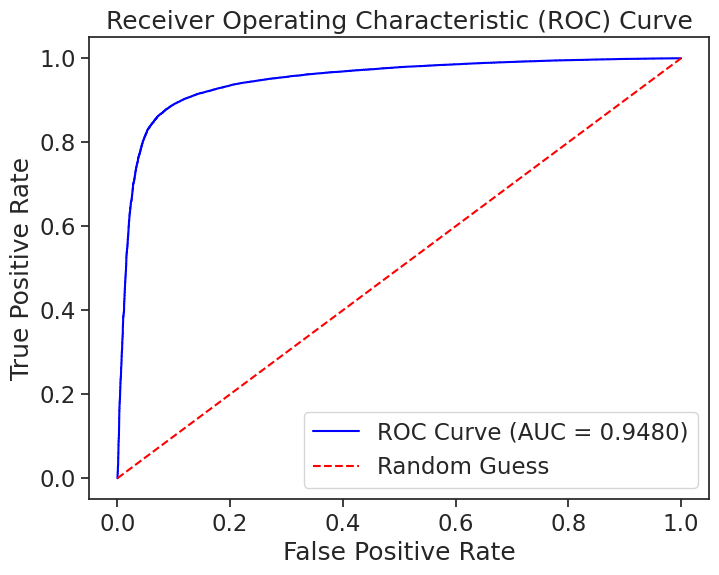

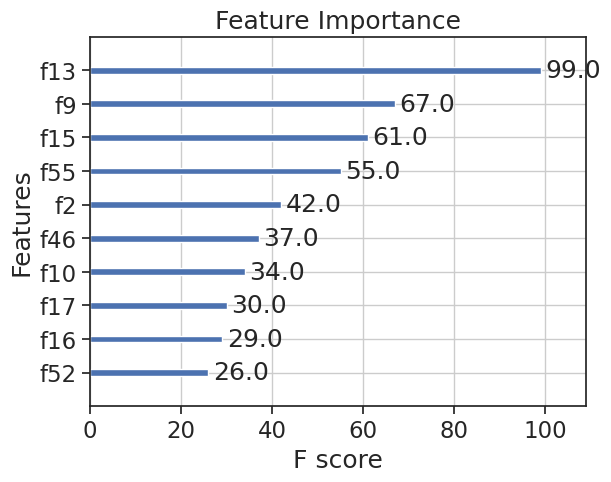

                     Feature  Importance
9       last_fico_range_high        99.0
6                        dti        67.0
10                 loan_amnt        61.0
49           credit_line_age        55.0
1                avg_cur_bal        42.0
..                       ...         ...
62             purpose_other         1.0
74             addr_state_IN         1.0
4   chargeoff_within_12_mths         1.0
72             addr_state_GA         1.0
90             addr_state_VA         1.0

[91 rows x 2 columns]


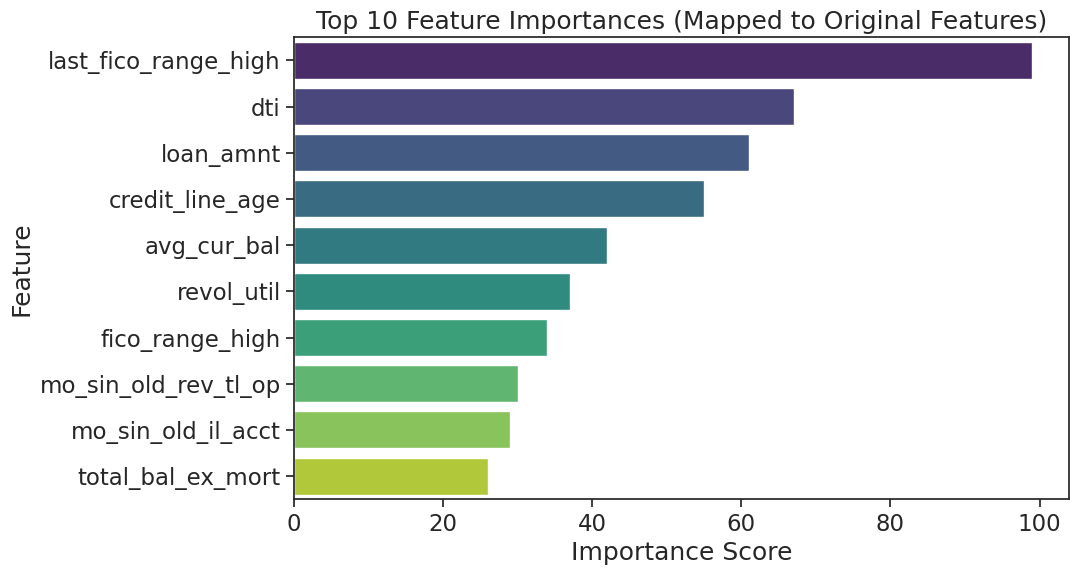

In [14]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define features and target variable
X = loan_df_cleaned.drop(columns=['fully_paid'], errors='ignore')  # Features
y = loan_df_cleaned['fully_paid']  # Target variable

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Ensure all columns are numeric
X = X.astype(float)

# Convert boolean columns to integers
X = X.astype({col: 'int' for col in X.select_dtypes('bool').columns})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Flip a portion of the labels in y_train --------
y_train = y_train.reset_index(drop=True)  # Reset index to ensure alignment with numpy indexing
flipped_indices = np.random.choice(y_train.index, size=int(0.1 * len(y_train)), replace=False)
y_train[flipped_indices] = 1 - y_train[flipped_indices]  # Flip 1 to 0 and 0 to 1

# Convert data to Numpy arrays for XGBoost compatibility
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Convert to XGBoost DMatrix for better performance
train_matrix = xgb.DMatrix(data=X_train, label=y_train)
test_matrix = xgb.DMatrix(data=X_test, label=y_test)

# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 6,
    "eta": 0.3,
    "seed": 42
}

# Train the model
eval_set = [(train_matrix, "train"), (test_matrix, "test")]
model = xgb.train(params, train_matrix, num_boost_round=100, evals=eval_set, early_stopping_rounds=10)

# Make predictions
y_pred = (model.predict(test_matrix) > 0.5).astype(int)
y_proba = model.predict(test_matrix)

# Evaluate the model
print("\nXGBoost Performance (with Flawed Labels):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot feature importance
xgb.plot_importance(model, max_num_features=10, importance_type="weight", title="Feature Importance")
plt.show()

# Recreate X_train with column names for feature mapping
X_train = pd.DataFrame(X_train, columns=X.columns)

# Retrieve feature importance from the trained model
importances = model.get_score(importance_type='weight')

# Map feature indices (f0, f1, ...) to original column names
feature_importance_df = pd.DataFrame({
    'Feature': [X_train.columns[int(f[1:])] for f in importances.keys()],
    'Importance': importances.values()
}).sort_values(by='Importance', ascending=False)

# Display the feature importance as a DataFrame
print(feature_importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances (Mapped to Original Features)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()